# Trending Youtube Video Statistics

The dataset was taken from:
 - [https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv](https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv)
 - [https://www.kaggle.com/datasnaek/youtube-new?select=US_category_id.json](https://www.kaggle.com/datasnaek/youtube-new?select=US_category_id.json)

## Preparation

### Import Libraries

In [692]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import sys
import warnings
import pickle
import json

from IPython.core.interactiveshell import InteractiveShell
from sklearn import preprocessing

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version:  1.20.3
pandas version:  1.3.4
seaborn version:  0.11.2
mlflow version:  1.22.0
last run:  2022-01-07 04:19:34


### Loading Datasets

#### Loading Video Data

In [693]:
# TODO: merge all regions and its categories

vdf = pd.read_csv('USvideos.csv')

# developer-friendly column names and format
vdf.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in vdf.columns.to_list()]

#### Loading Category Data

In [694]:
categories = {}
with open('US_category_id.json', 'r') as f:
    data = json.loads(f.read())

for item in data['items']:
    categories[item['id']] = item['snippet']['title']

cdf = pd.DataFrame({
    'category_id': categories.keys(),
    'category': categories.values(),
})

cdf.category_id = cdf.category_id.astype('int64')

#### Merging Data

In [695]:
dataset = vdf.merge(cdf, on='category_id')
dataset.drop(['category_id'], axis=1, inplace=True)

### Variables and Functions

In [696]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

binary_pallete = ['#EF4444', '#10B981']

def remove_outlier_iqr(df, col):
    filtered_entries = np.array([True] * len(df))
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries

    df = df[filtered_entries]
    return df

def eval_regression(pred, ytest):
    # print("MAE: %.2f" % mean_absolute_error(ytest, pred)) # The MAE
    # print("RMSE: %.2f" % mean_squared_error(ytest, pred, squared=False)) # The RMSE
    # print('R2 score: %.2f' % r2_score(ytest, pred)) # Explained variance score: 1 is perfect prediction

    return {
        'mae': mean_absolute_error(ytest, pred),
        'mae %': mean_absolute_percentage_error(ytest, pred),
        'rmse': mean_squared_error(ytest, pred, squared=False),
        'r2': r2_score(ytest, pred)
    }

## Data Information & Description

### Data Sample

In [697]:
dataset.sample(5, random_state=1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
22745,WArjc_PF2b4,18.06.02,"Stock market plunges, but it's not time to panic",CNN,2018-02-05T21:26:11.000Z,"latest News|""Happening Now""|""CNN""|""stock marke...",58231,397,90,1039,https://i.ytimg.com/vi/WArjc_PF2b4/default.jpg,False,False,False,CNN's Clare Sebastian says a perfect storm of ...,News & Politics
33187,MIQKlHSD89E,18.01.04,Tiny Donkey Thinks He's Actually A Dog | The ...,The Dodo,2018-03-23T21:00:01.000Z,"animal video|""animals""|""the dodo""|""Animal Resc...",3444015,103847,1069,6205,https://i.ytimg.com/vi/MIQKlHSD89E/default.jpg,False,False,False,Tiny Donkey Is Pretty Sure He's Actually A Dog...,Pets & Animals
12833,KyB0zVHm2P0,18.08.06,Shawn Mendes Destroys James In a Cover Battle ...,The Late Late Show with James Corden,2018-06-07T05:15:24.000Z,"The Late Late Show|""Late Late Show""|""James Cor...",1365473,100090,290,2427,https://i.ytimg.com/vi/KyB0zVHm2P0/default.jpg,False,False,False,When Shawn Mendes -- aka DJ Stitches -- shows ...,Entertainment
25194,W-FxnLAnlGg,18.21.03,Nevada comes back from 22 points down to knock...,NCAA March Madness,2018-03-19T00:24:40.000Z,2018 NCAA Men's Division I Basketball Tourname...,298315,2001,132,562,https://i.ytimg.com/vi/W-FxnLAnlGg/default.jpg,False,False,False,Nevada went on a 32-8 run and erased a 22-poin...,Sports
7802,rXbKeHAoA84,18.22.02,The Florida Project Should've Been Nominated,Nerdwriter1,2018-02-14T19:38:16.000Z,"the nerdwriter|""nerdwriter""|""nerdwriter youtub...",377833,27239,329,1453,https://i.ytimg.com/vi/rXbKeHAoA84/default.jpg,False,False,False,Why Sean Baker's The Florida Project should ha...,Entertainment


### Data Information

In [698]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   publish_time            40949 non-null  object
 5   tags                    40949 non-null  object
 6   views                   40949 non-null  int64 
 7   likes                   40949 non-null  int64 
 8   dislikes                40949 non-null  int64 
 9   comment_count           40949 non-null  int64 
 10  thumbnail_link          40949 non-null  object
 11  comments_disabled       40949 non-null  bool  
 12  ratings_disabled        40949 non-null  bool  
 13  video_error_or_removed  40949 non-null  bool  
 14  description             40379 non-null  object
 15  ca

- Features with missing value:
    - `description`
- Feature with binary/boolean value:
    - `comments_disabled`
    - `ratings_disabled`
    - `video_error_or_removed`

## Preprocessing

### Removing Unnecessary Features

In [699]:
dataset.drop(['video_id', 'thumbnail_link', 'description', 'trending_date', 'publish_time', 'tags'], axis=1, inplace=True)

# TODO: make use publish_time and trending_date for time series analysis later

### Removing Duplicated Data

In [700]:
print("before removal:", dataset.shape[0])

print("duplicated count:", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

print("after removal:", dataset.shape[0])

before removal: 40949
duplicated count: 48
after removal: 40901


### Preprocessing Result

In [701]:
dataset.sample(5, random_state=1)

,title,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category
34637,Questions about Concrete Answered - The Basics,Practical Engineering,227784,13027,113,1499,False,False,False,Education
32367,Troye Sivan - Bloom,TroyeSivanVEVO,2819592,251726,7835,23573,False,False,False,Music
33249,"MAINE COON – Characteristics, Character and Care",AnimalWised,157916,3366,51,363,False,False,False,Pets & Animals
30269,Jason Derulo - Colors (Official Music Video) T...,Jason Derulo,5269277,190309,11308,27687,False,False,False,Music
11659,Little Kid Runs in Slow Motion During Baseball...,RM Videos,308917,1513,245,473,False,False,False,Entertainment


## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [702]:
dataset.select_dtypes(include='number').describe()

,views,likes,dislikes,comment_count
count,4.090100e+04,4.090100e+04,4.090100e+04,4.090100e+04
mean,2.360678e+06,7.427173e+04,3.711722e+03,8.448567e+03
std,7.397719e+06,2.289999e+05,2.904624e+04,3.745139e+04
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.419720e+05,5.416000e+03,2.020000e+02,6.130000e+02
50%,6.810640e+05,1.806900e+04,6.300000e+02,1.855000e+03
75%,1.821926e+06,5.533800e+04,1.936000e+03,5.752000e+03
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


#### Categorical

In [703]:
dataset.select_dtypes(exclude='number').describe()

,title,channel_title,comments_disabled,ratings_disabled,video_error_or_removed,category
count,40901,40901,40901,40901,40901,40901
unique,6455,2207,2,2,2,16
top,Mission: Impossible - Fallout (2018) - Officia...,ESPN,False,False,False,Entertainment
freq,29,202,40269,40732,40878,9944


- binary features: `comments_disabled`, `ratings_disabled`, `video_error_or_removed`

### Univariate Analysis

#### Distribution

In [704]:
# temporary removing outlier before checking the distribution of numeric features

idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

current = int(idf.shape[0])
print("rows count before:", current, '\n')

number_cols = idf.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    idf = remove_outlier_iqr(idf, col)
    reducted = current - int(idf.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nrows count after:", current)

rows count before: 40901 

- views: 4497
- likes: 3544
- dislikes: 3036
- comment_count: 2062
total: 13139

rows count after: 27762


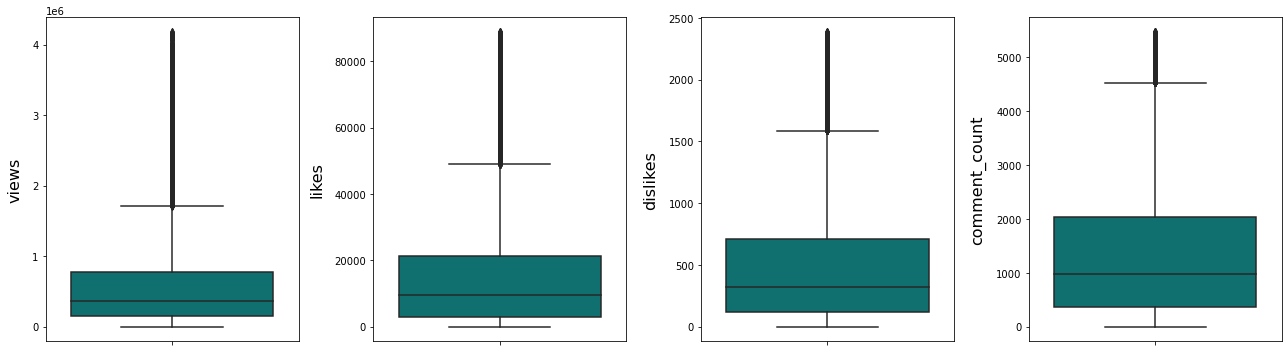

In [705]:
plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=idf[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

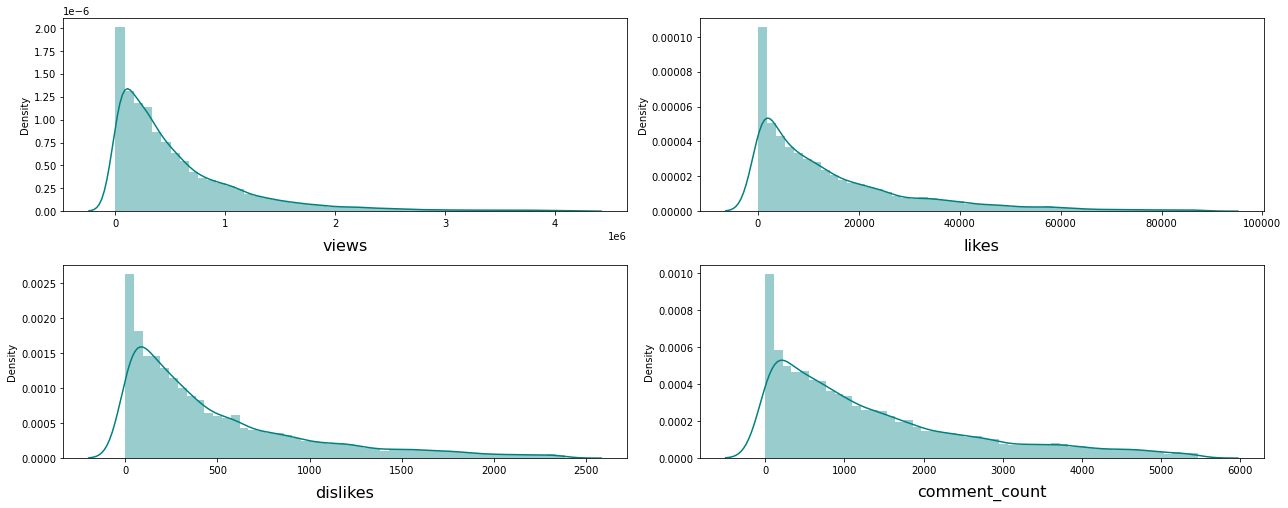

In [706]:
plt.figure(figsize=(18, 10))
for index in range(0, len(cols)):
    plt.subplot(3, len(cols)/2, index+1)
    sns.distplot(idf[cols[index]], color='teal')
    plt.xlabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

- The distribution for `views`, `likes`, `dislikes`, and `comment_count` has median centered near 0 value and has deviating outliers.

#### Comparison

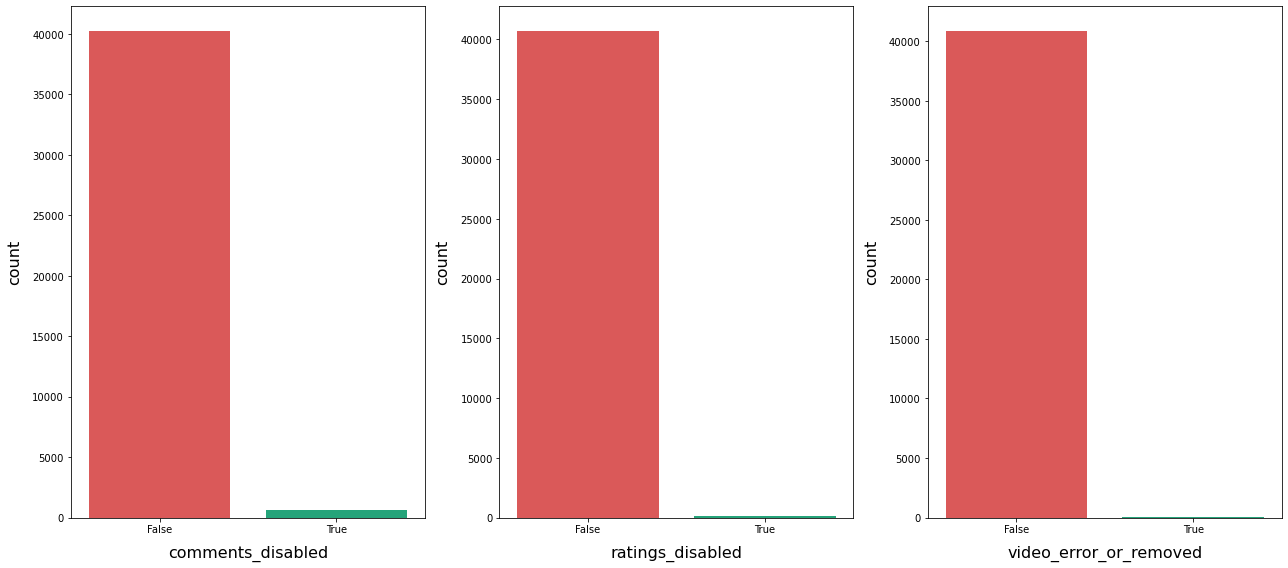

In [707]:
binary_features = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']

plt.figure(figsize=(18, 8))
for index in range(0, len(binary_features)):
    plt.subplot(1, 3, index+1)
    sns.countplot(dataset[binary_features[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(binary_features[index], fontsize='16', labelpad=10)
    plt.ylabel('count', fontsize='16', labelpad=10)

plt.show();

- All the binary features has class imbalance with `False` dominating over `True` value.

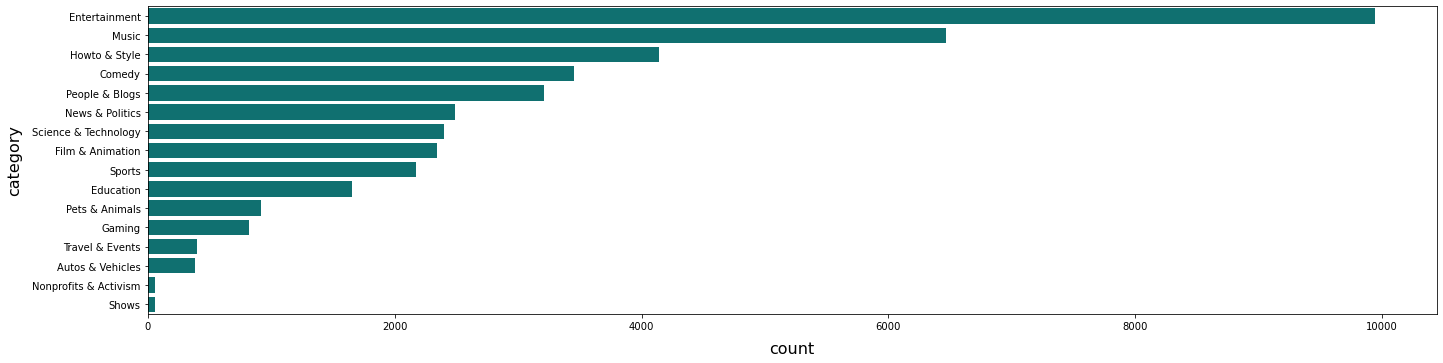

In [708]:
plt.figure(figsize=(20, 5))
sns.countplot(data=dataset, y='category', color='teal', order=dataset['category'].value_counts().index)
plt.tight_layout()
plt.ylabel('category', fontsize='16', labelpad=10)
plt.xlabel('count', fontsize='16', labelpad=10)
plt.show();

### Multivariate Analysis

#### Correlation Heatmap

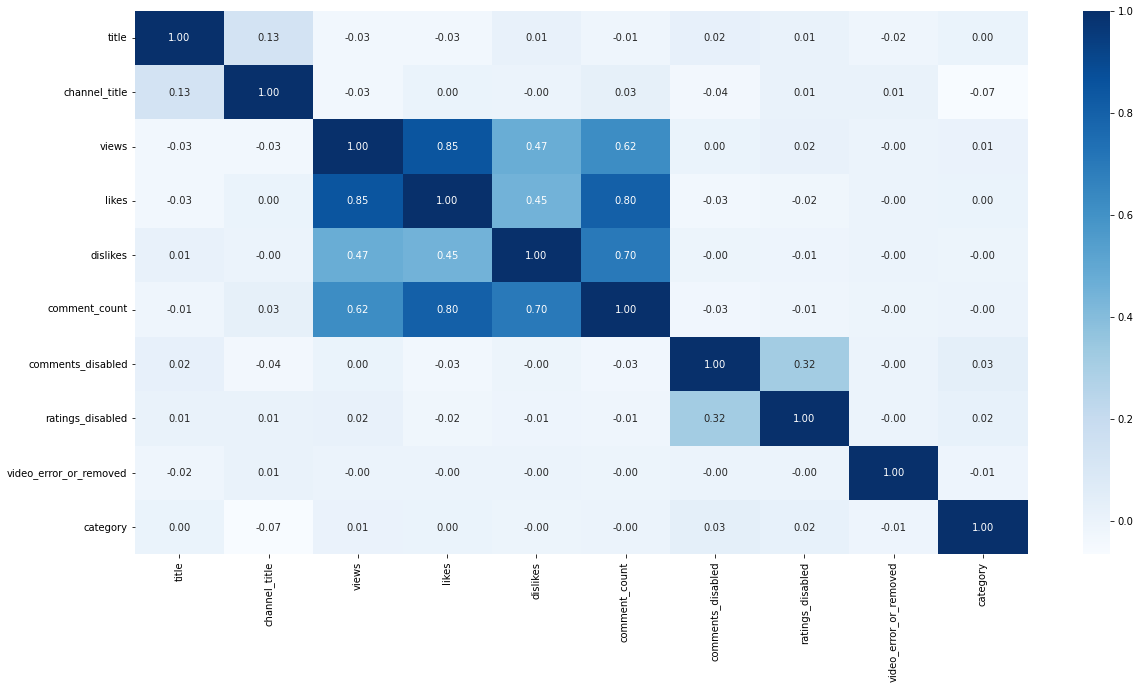

In [709]:
# label encoding for heatmap
idf = dataset.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

for predicting `views`, we could use features that has high correlation to the target. In this heatmap, we could see that `likes`, `dislikes`, and `comment_count` has high correlation to `views`.

#### Pairplots

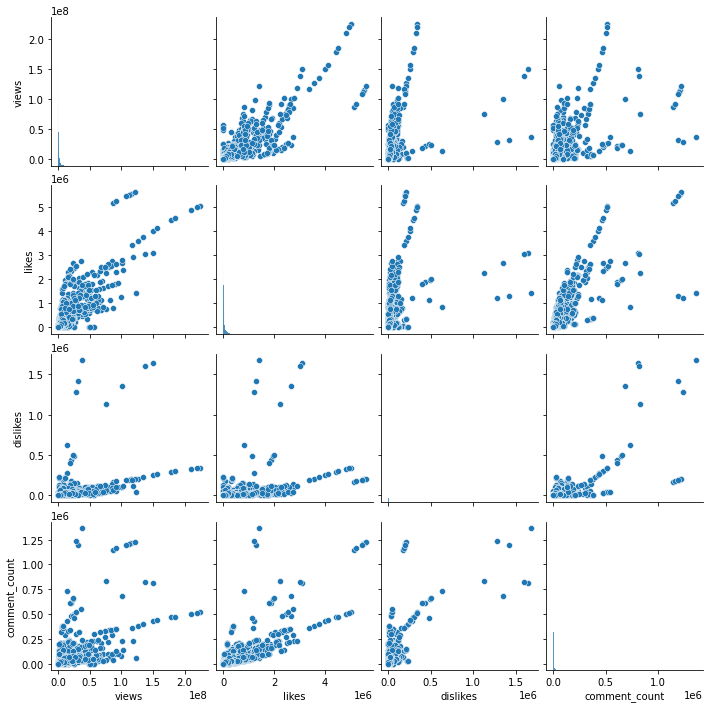

In [710]:
# select only numerical feature and non-categorical
idf = dataset.select_dtypes(include='number')
idf = idf.loc[:, ~idf.columns.isin(['category_id'])]

sns.pairplot(data=idf.sample(round(idf.shape[0]/2), random_state=1))
plt.show();

In the pairplot, we could see pairing `views` to the each features (`likes`, `dislikes`, `comment_count`) are approaching a linear pattern.

### Insights

Most Viewed Category

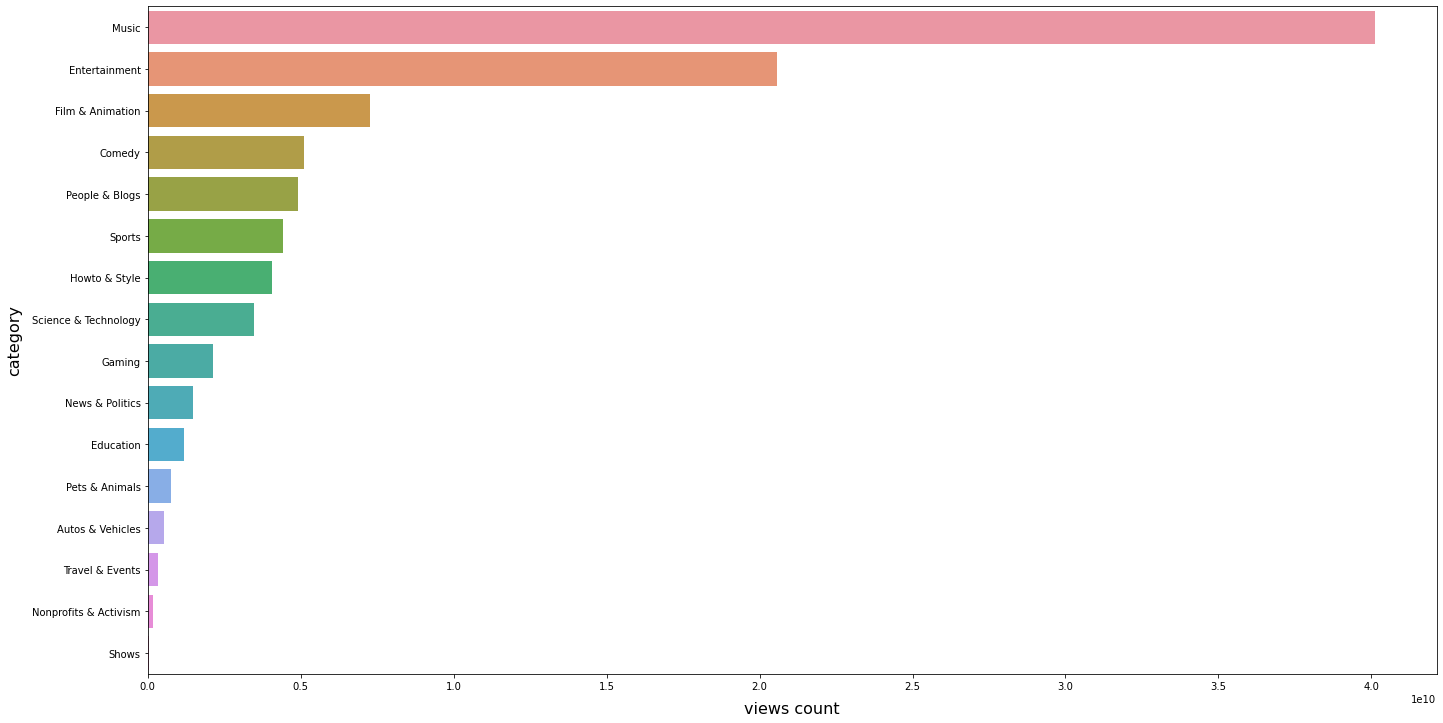

In [711]:
idf = dataset.groupby('category').sum().reset_index()

plt.figure(figsize=(20, 10))
sns.barplot(data=idf, y='category',x='views', order=idf[['category', 'views']].sort_values('views', ascending=False)['category'])
plt.tight_layout()
plt.ylabel('category', fontsize='16', labelpad=10)
plt.xlabel('views count', fontsize='16', labelpad=10)
plt.show();

Most Liked Category

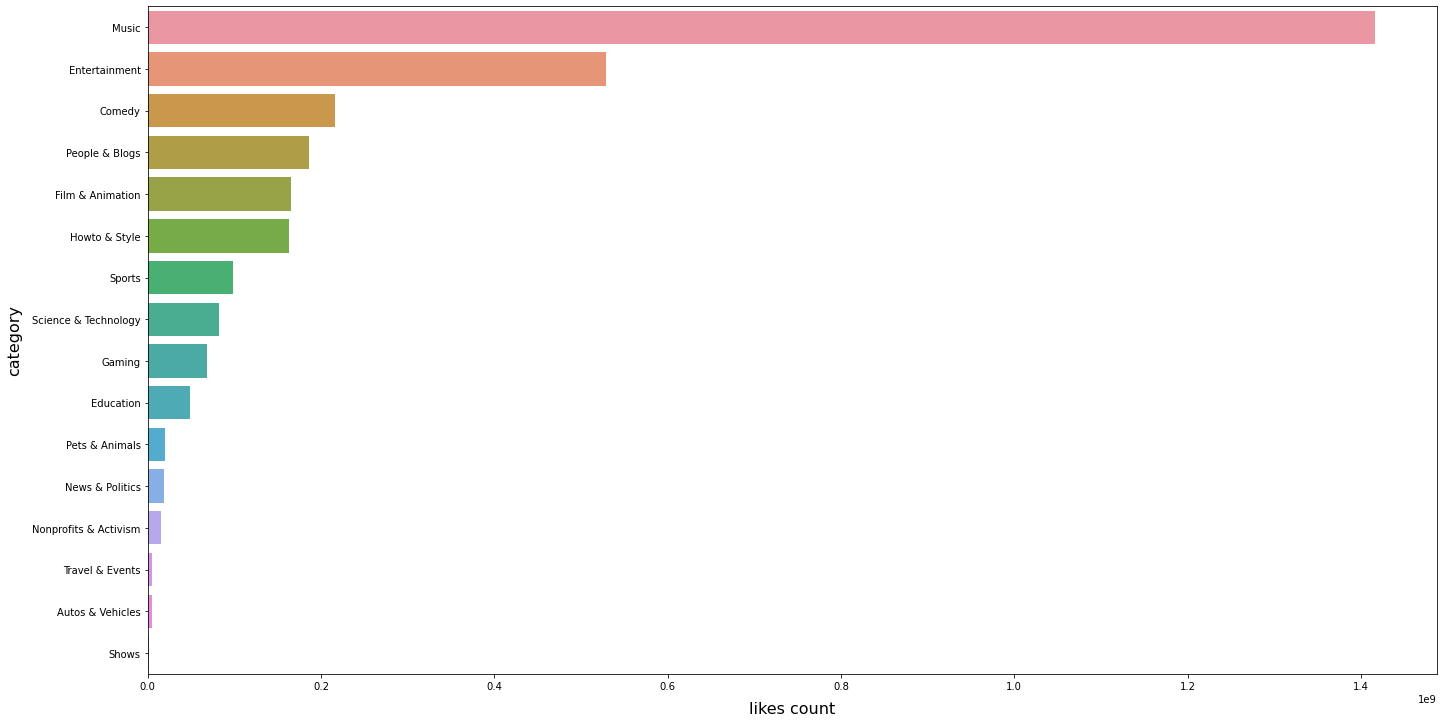

In [712]:
plt.figure(figsize=(20, 10))
sns.barplot(data=idf, y='category', x='likes', order=idf[['category', 'likes']].sort_values('likes', ascending=False)['category'])
plt.tight_layout()
plt.ylabel('category', fontsize='16', labelpad=10)
plt.xlabel('likes count', fontsize='16', labelpad=10)
plt.show();

Most Disliked Category

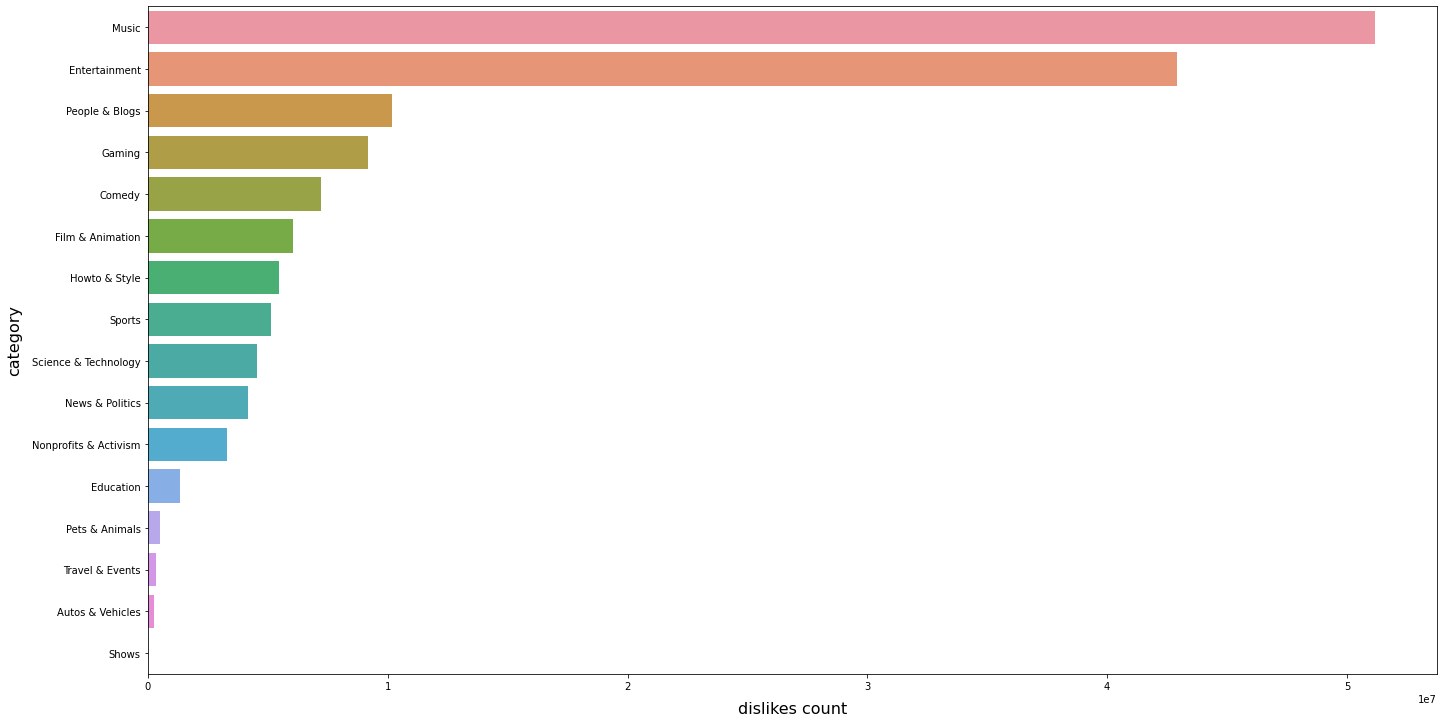

In [713]:
plt.figure(figsize=(20, 10))
sns.barplot(data=idf, y='category', x='dislikes', order=idf[['category', 'dislikes']].sort_values('dislikes', ascending=False)['category'])
plt.tight_layout()
plt.ylabel('category', fontsize='16', labelpad=10)
plt.xlabel('dislikes count', fontsize='16', labelpad=10)
plt.show();

Most Commented Category

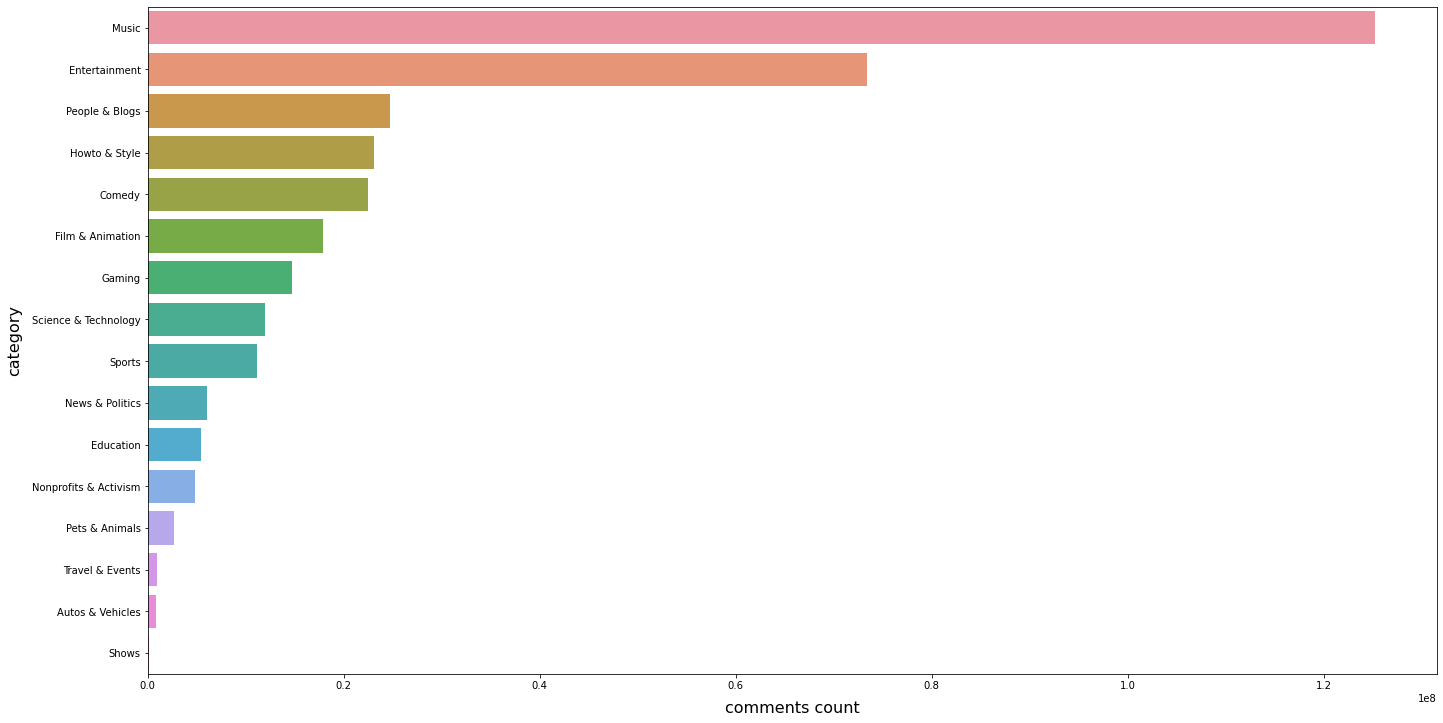

In [714]:
plt.figure(figsize=(20, 10))
sns.barplot(data=idf, y='category', x='comment_count', order=idf[['category', 'comment_count']].sort_values('comment_count', ascending=False)['category'])
plt.tight_layout()
plt.ylabel('category', fontsize='16', labelpad=10)
plt.xlabel('comments count', fontsize='16', labelpad=10)
plt.show();

## Feature Engineering

### Feature Selection

In [715]:
dataset = dataset[['views', 'likes', 'dislikes', 'comment_count']]
dataset.columns.tolist()

['views', 'likes', 'dislikes', 'comment_count']

In [716]:
numerical_limits = {}
for col in dataset.select_dtypes(include='number').columns.tolist():
    numerical_limits[col] = [dataset[col].min(), dataset[col].max()]

pickle.dump(numerical_limits, open('numerical_limits.pickle', 'wb'))

### Outlier Removal

In [717]:
current = int(dataset.shape[0])
print("rows count before:", current, '\n')

number_cols = dataset.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    dataset = remove_outlier_iqr(dataset, col)
    reducted = current - int(dataset.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nrows count after:", current)

rows count before: 40901 

- views: 4497
- likes: 3544
- dislikes: 3036
- comment_count: 2062
total: 13139

rows count after: 27762


### Feature Scaling

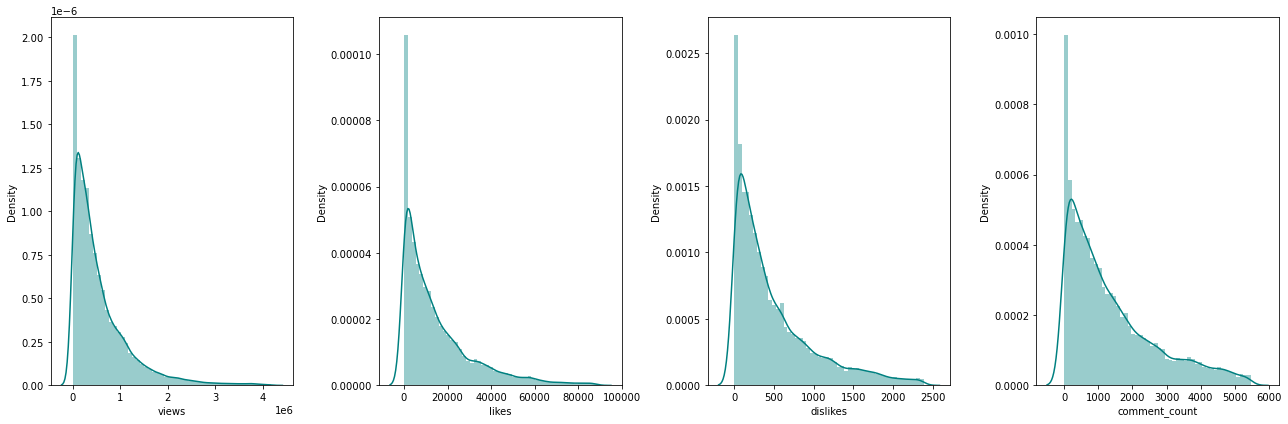

In [718]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(idf[cols[index]], color='teal')
    plt.tight_layout()

plt.show();

Since the four features doesn't have normal/gaussian distribution, we will perform Normalization/MinMaxScaler to the features instead of Standardization

In [719]:
from sklearn.preprocessing import MinMaxScaler

print("before scaling:")
dataset[cols].sample(5, random_state=1)

for col in cols:
    scaler = MinMaxScaler().fit(dataset[col].values.reshape(len(dataset), 1))
    dataset[col] = scaler.transform(dataset[col].values.reshape(len(dataset), 1))
    pickle.dump(scaler, open('scaler_' + col + '.pickle', 'wb'))


print("after scaling:")
dataset[cols].sample(5, random_state=1)

before scaling:


,views,likes,dislikes,comment_count
18282,382023,45652,586,1387
21406,727427,9459,1446,3292
26611,443055,13421,116,317
9580,532370,4088,1258,480
31507,1114794,44172,753,2467


after scaling:


,views,likes,dislikes,comment_count
18282,0.091353,0.514400,0.245702,0.253519
21406,0.174069,0.106583,0.606289,0.601718
26611,0.105969,0.151226,0.048637,0.057942
9580,0.127358,0.046063,0.527463,0.087735
31507,0.266833,0.497724,0.315723,0.450923


## Regression Modeling

### Data Split

In [720]:
predictors = dataset.loc[:, ~dataset.columns.isin(['views'])]
target = dataset[['views']]

print("predictors:", predictors.columns.tolist())
print("target:", target.columns.tolist())

predictors: ['likes', 'dislikes', 'comment_count']
target: ['views']


In [721]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2, random_state = 1)

pd.DataFrame({
    'x_train': [x_train.shape],
    'x_test': [x_test.shape],
    'y_train': [y_train.shape],
    'y_test': [y_test.shape],
})

,x_train,x_test,y_train,y_test
0,"(22209, 3)","(5553, 3)","(22209, 1)","(5553, 1)"


### Model Training

#### Linear Regression

In [722]:
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

LinearRegression()

#### Ridge (Hyperparameter Tuning)

In [723]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# list of scoring types: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

ridge_hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 0.3, 0.6, 1, 10],
    'solver': ['auto', 'lsqr', 'sag', 'saga', 'cholesky'],
}

ridge_model = Ridge()
clf = GridSearchCV(ridge_model, ridge_hyperparameters, cv=5, scoring='neg_mean_absolute_error')
ridge_best_model = clf.fit(x_train, y_train)

ridge_best_model.best_params_

{'alpha': 0.001, 'solver': 'saga'}

### Lasso (Hyperparameter Tuning)

In [724]:
from sklearn.linear_model import Lasso

lasso_hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 0.3, 0.6, 1, 10],
    'selection': ['cyclic', 'random']
}

lasso_model = Lasso()
clf = GridSearchCV(lasso_model, lasso_hyperparameters, cv=5, scoring='neg_mean_absolute_error')
lasso_best_model = clf.fit(x_train, y_train)

lasso_best_model.best_params_

{'alpha': 0.001, 'selection': 'cyclic'}

#### ElasticNet (Hyperparameter Tuning)

In [725]:
from sklearn.linear_model import ElasticNet

elasticnet_hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 0.3, 0.6, 1, 10],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

elasticnet_model = ElasticNet()
clf = GridSearchCV(elasticnet_model, elasticnet_hyperparameters, cv=5, scoring='neg_mean_absolute_error')
elasticnet_best_model = clf.fit(x_train, y_train)

elasticnet_best_model.best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

#### Decision Tree Regressor

In [726]:
from sklearn.tree import DecisionTreeRegressor
dtreg_model = DecisionTreeRegressor()
dtreg_model.fit(x_train, y_train)

DecisionTreeRegressor()

#### Random Forest

In [687]:
from sklearn.ensemble import RandomForestRegressor
randomforest_model = RandomForestRegressor()
randomforest_model.fit(x_train, y_train)

RandomForestRegressor()

### Support Vector Regressor

In [688]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(x_train, y_train)

SVR()

### Model Evaluation

In [689]:
eval_linear_regression_model = eval_regression(linear_regression_model.predict(x_test), y_test)
eval_ridge_best_model = eval_regression(ridge_best_model.predict(x_test), y_test)
eval_lasso_best_model = eval_regression(lasso_best_model.predict(x_test), y_test)
eval_elasticnet_best_model = eval_regression(elasticnet_best_model.predict(x_test), y_test)
eval_dtreg_model = eval_regression(dtreg_model.predict(x_test), y_test)
eval_randomforest_model = eval_regression(randomforest_model.predict(x_test), y_test)
eval_svr_model = eval_regression(svr_model.predict(x_test), y_test)

pd.DataFrame({
    'Linear Regression': eval_linear_regression_model,
    'Ridge (Hyperparameter Tuned)': eval_ridge_best_model,
    'Lasso (Hyperparameter Tuned)': eval_lasso_best_model,
    'ElasticNet (Hyperparameter Tuned)': eval_elasticnet_best_model,
    'DecisionTree Regressor': eval_dtreg_model,
    'Random Forest': eval_randomforest_model,
    'Support Vector Regressor': eval_svr_model,
}).transpose()

,mae,mae %,rmse,r2
Linear Regression,0.063815,2.551247,0.107169,0.488626
Ridge (Hyperparameter Tuned),0.063824,2.555649,0.107170,0.488623
Lasso (Hyperparameter Tuned),0.064659,2.914044,0.107452,0.485928
ElasticNet (Hyperparameter Tuned),0.064049,2.635929,0.107250,0.487857
DecisionTree Regressor,0.052925,0.794827,0.112021,0.441276
Random Forest,0.045137,0.775919,0.085565,0.674022
Support Vector Regressor,0.082920,8.657111,0.111971,0.441774


## Model Deployment

### Persist Model

In [690]:
pickle.dump(randomforest_model, open('model.pickle', 'wb'))

### Test Model

In [691]:
model = pickle.load(open('model.pickle', 'rb'))
scaler_views = pickle.load(open('scaler_views.pickle', 'rb'))
scaler_likes = pickle.load(open('scaler_likes.pickle', 'rb'))
scaler_dislikes = pickle.load(open('scaler_dislikes.pickle', 'rb'))
scaler_comment_count = pickle.load(open('scaler_comment_count.pickle', 'rb'))

likes = 251726
dislikes = 7835
comment_count = 23573

inputs = pd.DataFrame({
    'likes': [scaler_likes.transform(np.array([likes]).reshape(1, -1))[0][0]],
    'dislikes': [scaler_dislikes.transform(np.array([dislikes]).reshape(1, -1))[0][0]],
    'comment_count': [scaler_comment_count.transform(np.array([comment_count]).reshape(1, -1))[0][0]]
})

output = model.predict(inputs)
scaler_views.inverse_transform([output])[0][0]

2448833.1499999994